In [149]:
import numpy as np
import pandas as pd
from tbparse import SummaryReader
import matplotlib.pyplot as plt
import seaborn as sns

In [150]:
env_names = ["cartpole", "minigrid-unlock"]
env_name = env_names[1]

cartpole_starting_from_steps = 0#200_000 # set this to 200_000 to have a plot where our implementation was better

log_dir = f"../data/logs/{env_name}/train"
reader = SummaryReader(log_dir, extra_columns={"dir_name"})
df = reader.scalars

df["ALG_ENV"] = df["dir_name"].apply(lambda x: "-".join(x.split("/")[1::]))
df.head(10)

,step,tag,value,dir_name,ALG_ENV
0,2500,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
1,5000,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
2,7500,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
3,10000,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
4,12500,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
5,15000,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
6,17500,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
7,20000,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
8,22500,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1
9,25000,eval/mean_ep_length,288.0,0/normal/128/logs/DQN_1,normal-128-logs-DQN_1


In [151]:
algs_envs = df["ALG_ENV"].unique()
algs_envs

array(['normal-128-logs-DQN_1', 'pretrain_combined-128-logs-DQN_1',
       'normal-128-logs-DQN_2'], dtype=object)

In [152]:
def percentile_lower(x: pd.Series) -> pd.DataFrame:
    return np.percentile(x, 20)

def percentile_upper(x: pd.Series) -> pd.DataFrame:
    return np.percentile(x, 80)

df_pivot = df[df["tag"] == "eval/mean_reward"].pivot_table(
        index="step",
        columns="ALG_ENV",
        values="value",
        aggfunc=[np.median, percentile_lower, percentile_upper],
)
df_pivot.head()

/tmp/ipykernel_35462/2794522608.py:7: FutureWarning: The provided callable <function median at 0x7d06b2ba4360> is currently using DataFrameGroupBy.median. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "median" instead.
  df_pivot = df[df["tag"] == "eval/mean_reward"].pivot_table(


median                        \
ALG_ENV normal-128-logs-DQN_1 normal-128-logs-DQN_2   
step                                                  
2500                      0.0                   0.0   
5000                      0.0                   0.0   
7500                      0.0                   0.0   
10000                     0.0                   0.0   
12500                     0.0                   0.0   

                                              percentile_lower  \
ALG_ENV pretrain_combined-128-logs-DQN_1 normal-128-logs-DQN_1   
step                                                             
2500                                 0.0                   0.0   
5000                                 0.0                   0.0   
7500                                 0.0                   0.0   
10000                                0.0                   0.0   
12500                                0.0                   0.0   

                                                                \
ALG_ENV normal-128-logs-DQN_2 pretrain_combined-128-logs-DQN_1   
step                                                             
2500                      0.0                              0.0   
5000                      0.0                              0.0   
7500                      0.0                              0.0   
10000                     0.0                              0.0   
12500                     0.0                              0.0   

             percentile_upper                        \
ALG_ENV normal-128-logs-DQN_1 normal-128-logs-DQN_2   
step                                                  
2500                      0.0                   0.0   
5000                      0.0                   0.0   
7500                      0.0                   0.0   
10000                     0.0                   0.0   
12500                     0.0                   0.0   

                                          
ALG_ENV pretrain_combined-128-logs-DQN_1  
step                                      
2500                                 0.0  
5000                                 0.0  
7500                                 0.0  
10000                                0.0  
12500                                0.0

In [153]:
if env_name == "minigrid-unlock" and False:
    # show starting from step 150_000
    df_pivot = df_pivot[df_pivot.index >= cartpole_starting_from_steps].copy()

    # make the columns to the cumulative sum
    for col_name in df_pivot.columns:
        df_pivot[col_name] = df_pivot[col_name].cumsum()

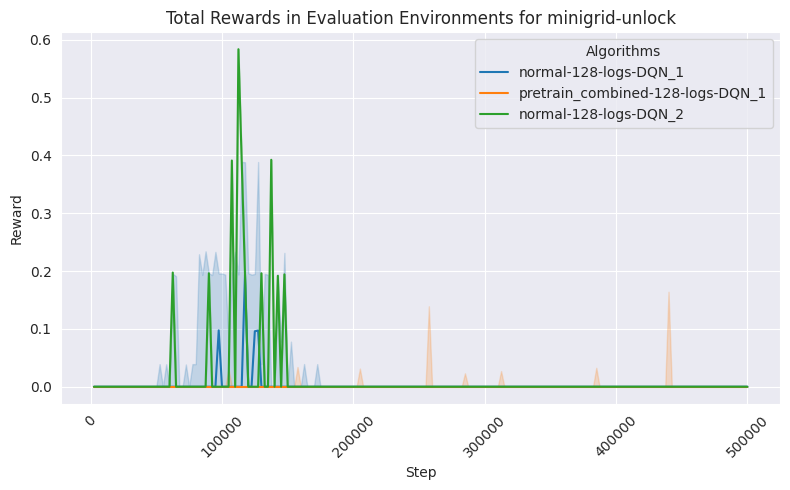

In [156]:
# Start plot
plt.figure(figsize=(8, 5))

# Get color palette
palette = sns.color_palette("tab10", len(algs_envs))

# Loop through each group
for i, group in enumerate(algs_envs):
    if group.find("qloss") != -1:
        continue

    # Plot line using seaborn
    sns.lineplot(x=df_pivot.index, y=df_pivot["median"][group], label=group, color=palette[i])

    # Add error bounds
    plt.fill_between(
        df_pivot.index,
        df_pivot["percentile_lower"][group],
        df_pivot["percentile_upper"][group],
        alpha=0.2,
        color=palette[i],
    )

# Final touches
plt.xlabel("Step")
plt.ylabel("Reward")
plt.title(f"Total Rewards in Evaluation Environments for {env_name}")
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title="Algorithms")

plt.savefig(f"{env_name}_out.png")

In [155]:
! pwd && ls ..

/home/niklas/Projects/RLProject_StateEmbeddings/src
data						     move_to_s3.sh   src
embedding_net_minigrid-unlock-pretrain_combined.pth  output.png      tests
flake.lock					     pyproject.toml  uv.lock
flake.nix					     README.md
logs						     remote_logs
